# Forecasting using ML models

## Import necessary libraries

In [1]:
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.dates as mdates
from scipy import stats
import holidays
from data.data_functions import *

warnings.filterwarnings("ignore")

In [2]:
dfs_dict = read_folder_to_dfs("./data/timesdata")
fin_data_hourly = create_hourly_obt(dfs_dict)
fin_data_hourly["skift_type"] = fin_data_hourly.apply(add_shift_type, axis=1)
fin_data_hourly = fin_data_hourly[fin_data_hourly["post"] == "medisinsk"]
# fin_data_hourly["Belegg"] = fin_data_hourly.apply(calculate_patients, axis=1)

## EDA

### Exploring dataset characteristics

In [3]:
print(fin_data_hourly.info())
print("__"*50)
print(fin_data_hourly.describe())
print("__"*50)
missing_values = fin_data_hourly.isnull().sum()
print("Missing values pr col:\n", missing_values)

<class 'pandas.core.frame.DataFrame'>
Index: 41820 entries, 1 to 83548
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   År                           41820 non-null  int32         
 1   Måned                        41820 non-null  object        
 2   Uke                          41820 non-null  UInt32        
 3   Dag                          41820 non-null  object        
 4   DatoTid                      41820 non-null  datetime64[ns]
 5   Timer                        41820 non-null  int32         
 6   post                         41820 non-null  object        
 7   helg                         41820 non-null  int64         
 8   Antall inn på post           41820 non-null  float64       
 9   Antall pasienter ut av Post  41820 non-null  float64       
 10  skift_type                   41820 non-null  object        
dtypes: UInt32(1), datetime64[ns](1), float64(2), i

### Adding rows for remainder of 2024

In [4]:
last_timestamp = pd.to_datetime("2024-10-14 23:00:00")
new_dates = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1), 
                          end="2024-12-31 23:00:00", 
                          freq='H')

missing_df = pd.DataFrame(new_dates, columns=['DatoTid'])
missing_df['År'] = missing_df['DatoTid'].dt.year
missing_df['Måned'] = missing_df['DatoTid'].dt.month
missing_df['Uke'] = missing_df['DatoTid'].dt.isocalendar().week
missing_df['Dag'] = missing_df['DatoTid'].dt.weekday
missing_df['Timer'] = missing_df['DatoTid'].dt.hour
missing_df['post'] = "medisinsk"
missing_df['helg'] = missing_df['Dag'].apply(lambda x: 1 if x in [5, 6] else 0)
missing_df['skift_type'] = missing_df.apply(add_shift_type, axis=1) 


df = pd.concat([fin_data_hourly, missing_df], ignore_index=True).sort_values(by='DatoTid').reset_index(drop=True)


### Imputing missing rows for remainder of 2024

In [5]:
hourly_mean_inn = df.groupby('Timer')['Antall inn på post'].transform('mean')
hourly_mean_inn = (hourly_mean_inn + 0.2)
df['Antall inn på post'] = df['Antall inn på post'].fillna(hourly_mean_inn)

hourly_mean_ut = df.groupby('Timer')['Antall pasienter ut av Post'].transform('mean')
hourly_mean_ut = (hourly_mean_ut + 0.2)
df['Antall pasienter ut av Post'] = df['Antall pasienter ut av Post'].fillna(hourly_mean_ut)

df["Belegg"] = df.apply(calculate_patients, axis=1)

## Feature Engineering

### Feature Transformation

In [6]:
# Demand kolonnen
df["demand"] = round(df['Antall pasienter ut av Post'],0) + round(df["Belegg"],0)
df['månedsdag'] = df['DatoTid'].dt.day
# Måned og Dag til numeriske verdier
month_mapping = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}

day_mapping = {
    'Monday': int(0), 'Tuesday': int(1), 'Wednesday': int(2), 'Thursday': int(3),
    'Friday': int(4), 'Saturday': int(5), 'Sunday': int(6)
}

df['Måned'] = df['Måned'].apply(lambda x: month_mapping[x] if isinstance(x, str) else x)
df['Dag'] = df['Dag'].apply(lambda x: day_mapping[x] if isinstance(x, str) else x)

df['månedsdag'] = df['DatoTid'].dt.day
# Encoding til sykliske features
df['hour_sin'] = np.sin(2 * np.pi * df['Timer'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['Timer'] / 24)

df['weekday_sin'] = np.sin(2 * np.pi * df['Dag'] / 7)
df['weekday_cos'] = np.cos(2 * np.pi * df['Dag'] / 7)

# Laggede og rullende features
## Timer
df['demand_lag1'] = df['demand'].shift(1)
df['demand_lag2'] = df['demand'].shift(2)
df['demand_lag3'] = df['demand'].shift(3)
df['demand_lag4'] = df['demand'].shift(4)

## Dager
df['demand_lag24'] = df['demand'].shift(24)
df['demand_lag48'] = df['demand'].shift(48)
df['demand_lag72'] = df['demand'].shift(72)
df['demand_lag96'] = df['demand'].shift(96)
df['demand_lag120'] = df['demand'].shift(120)
df['demand_lag144'] = df['demand'].shift(144)
df['demand_lag168'] = df['demand'].shift(168)
df['demand_lag720'] = df['demand'].shift(720)

## Gjennomsnitt over siste dager
df['demand_roll24'] = df['demand'].rolling(window=24).mean()
df['demand_roll48'] = df['demand'].rolling(window=48).mean()
df['demand_roll72'] = df['demand'].rolling(window=72).mean()
df['demand_roll96'] = df['demand'].rolling(window=96).mean()
df['demand_roll120'] = df['demand'].rolling(window=120).mean()
df['demand_roll144'] = df['demand'].rolling(window=144).mean()
df['demand_roll168'] = df['demand'].rolling(window=168).mean()
df['demand_roll720'] = df['demand'].rolling(window=720).mean()

# Helligdager i Norge
# norwegian_holidays = holidays.Norway(years=range(2020, 2025))
# df['is_holiday'] = df['DatoTid'].apply(lambda x: 1 if x in norwegian_holidays else 0)
# df['holiday_name'] = df['DatoTid'].apply(lambda x: norwegian_holidays.get(x) if x in norwegian_holidays else "None")

df['is_holiday'] = 0
hol = holidays.Norway(years=range(2020, 2025))
translated_holidays = {'Andre påskedag' : "Easter",
'Andre juledag' : "Christmas",
'Arbeidernes dag' : "Worker's day",
'Første juledag' : "Christmas",
'Kristi himmelfartsdag' : "Easter",
'Skjærtorsdag' : "Easter",
'Andre pinsedag' : "Pentecost",
'Første pinsedag' : "Pentecost",
'Langfredag' : "Easter",
'Første nyttårsdag': "New year",
'Grunnlovsdag' : "Constitution day",
'Første påskedag' : "Easter"}

for date, holiday in hol.items():
    df.loc[str(date), "is_holiday"] = translated_holidays[holiday]
df.loc[(df["Måned"] == 12) & (df["månedsdag"] == 31), "is_holiday"] = "New year"
df.loc[(df["Måned"] == 12) & (df["månedsdag"] >= 21) & (df["månedsdag"] <= 28), "is_holiday"] = "Christmas"

for holiday in translated_holidays.values():
    df[holiday] = 0
    df.loc[df["is_holiday"] == holiday, holiday] = 1
df.drop(columns= ["is_holiday"], inplace = True)
df.dropna(subset= ["månedsdag"], inplace = True)
seasons = {1: "Winter", 2:"Spring", 3: "Summer", 4:"Autumn"}
months_to_seasons = dict(zip(list(range(1,13)), [1]*2 + [2]*3 + [3]*3 + [4]*3 + [1] *1))
df["årssesong"] = df.Måned.apply(lambda x: months_to_seasons[x])



# Dropper rader med nan verdier i lagged og rullende kolonner
df = df.dropna()
df = df.reset_index(drop=True)

# Onehot encode skift type
df = pd.get_dummies(df, columns=['skift_type'], drop_first=False)

# Dropper unødvendige kolonner
df = df.drop(columns=['post'])


## Train & Test

### Korrelasjonsmatrise

In [7]:
correlation_matrix = df.corr()
high_corr_features = correlation_matrix.index[correlation_matrix['demand'].abs() > 0.85]
high_corr_features = high_corr_features.drop('demand')

In [8]:
split_ratio = 0.8
split_index = int(len(df) * split_ratio)

train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

# print(f"Training set size: {train_df.shape}")
# print(f"Testing set size: {test_df.shape}")

# Definer features og target
features = [col for col in df.columns if col not in ['demand', "DatoTid", "demand_roll720", "demand_lag120", "demand_lag144", "demand_lag72", 
                                                     "Antall inn på post", "demand_roll72", "demand_roll96", "demand_roll120", "demand_lag48", 
                                                     "Antall pasienter ut av Post", "demand_lag168", "demand_lag96", "demand_lag24", 
                                                     "demand_lag720", "demand_roll168", "demand_roll48", "demand_roll144"]] 
target = 'demand'
X_train, y_train = train_df[features], train_df[target]
X_test, y_test = test_df[features], test_df[target]

# Drop kolonnene med høy korrelasjon
X_train_filtered = X_train.drop(columns=high_corr_features, errors='ignore')
X_test_filtered = X_test.drop(columns=high_corr_features, errors='ignore')

# XGBoost regressor modell (v1)
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=6)

# Trene modellen
xg_reg.fit(X_train_filtered, y_train)

# Predikere
y_pred = xg_reg.predict(X_test_filtered)

# Evaluering av modellen på metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

RMSE: 5.2659314617453665


## Hyper-parameter tuning

In [9]:
# Parameter griddet for tuningprosessen
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

xg_reg = xgb.XGBRegressor(objective='reg:squarederror')
random_search = RandomizedSearchCV(
    estimator=xg_reg, 
    param_distributions=param_grid, 
    n_iter=20, 
    scoring='neg_mean_squared_error', 
    cv=3, 
    verbose=1, 
    random_state=42
)

# Fit mpå treningsdataen
random_search.fit(X_train_filtered, y_train)

# Hent beste modell
best_xg_reg = random_search.best_estimator_
print("Best parameters:", random_search.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'subsample': 0.7, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.7}


## Bruke beste modell

In [10]:
y_pred = best_xg_reg.predict(X_test_filtered)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"Test RMSE: {rmse}")
print(f"Test MAE: {mae}")

Test RMSE: 5.03757947919103
Test MAE: 4.241471741184236


## Plotte feature importance

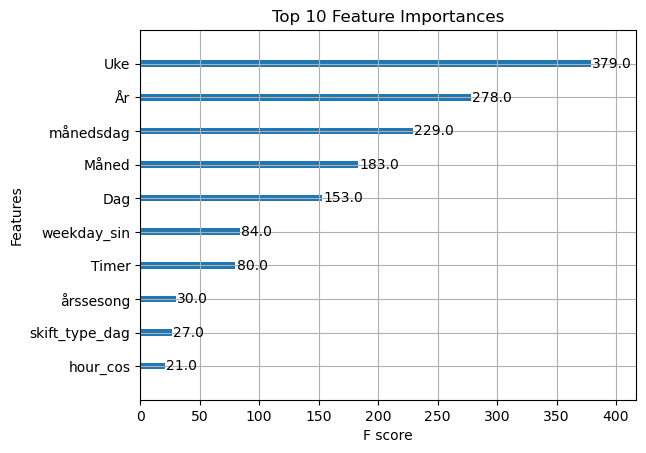

In [11]:
xgb.plot_importance(best_xg_reg, max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.show()

## Plotte prediksjoner vs faktisk etterspørsel

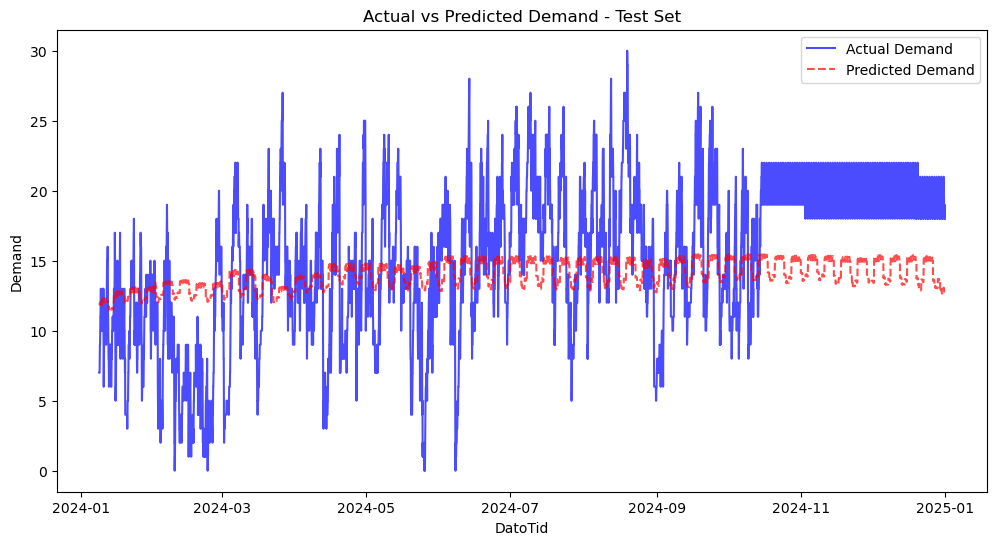

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(test_df['DatoTid'], y_test, label='Actual Demand', color='blue', alpha=0.7)
plt.plot(test_df['DatoTid'], y_pred, label='Predicted Demand', color='red', linestyle='--', alpha=0.7)
plt.xlabel('DatoTid')
plt.ylabel('Demand')
plt.title('Actual vs Predicted Demand - Test Set')
plt.legend()
plt.show()

## Future Predictions

In [13]:
start_date = df['DatoTid'].max() + pd.Timedelta(hours=1)  
end_date = start_date + pd.DateOffset(months=6) 


future_dates = pd.date_range(start=start_date, end=end_date, freq='H')
future_df = pd.DataFrame({'DatoTid': future_dates})

future_df['År'] = future_df['DatoTid'].dt.year
future_df['Måned'] = future_df['DatoTid'].dt.month
future_df['Uke'] = future_df['DatoTid'].dt.isocalendar().week
future_df['Dag'] = future_df['DatoTid'].dt.weekday
future_df['Timer'] = future_df['DatoTid'].dt.hour
future_df['post'] = "medisinsk"
future_df['helg'] = future_df['Dag'].apply(lambda x: 1 if x in [5, 6] else 0)
future_df['skift_type'] = future_df.apply(add_shift_type, axis=1) 

future_df['månedsdag'] = future_df['DatoTid'].dt.day

# Encoding til sykliske features
future_df['hour_sin'] = np.sin(2 * np.pi * future_df['Timer'] / 24)
future_df['hour_cos'] = np.cos(2 * np.pi * future_df['Timer'] / 24)

future_df['weekday_sin'] = np.sin(2 * np.pi * future_df['Dag'] / 7)
future_df['weekday_cos'] = np.cos(2 * np.pi * future_df['Dag'] / 7)

# Helligdager i Norge
norwegian_holidays = holidays.Norway(years=range(2020, 2025))
future_df['is_holiday'] = future_df['DatoTid'].apply(lambda x: 1 if x in norwegian_holidays else 0)
future_df['holiday_name'] = future_df['DatoTid'].apply(lambda x: norwegian_holidays.get(x) if x in norwegian_holidays else "None")

# Dropper rader med nan verdier i lagged og rullende kolonner
future_df = future_df.dropna()
future_df = future_df.reset_index(drop=True)

# Onehot encode skift type
future_df = pd.get_dummies(future_df, columns=['skift_type'], drop_first=False)

# Dropper unødvendige kolonner
future_df = future_df.drop(columns=['post', "holiday_name"])

In [14]:
future_df['is_holiday'] = 0
hol = holidays.Norway(years=range(2020, 2025))
translated_holidays = {'Andre påskedag' : "Easter",
'Andre juledag' : "Christmas",
'Arbeidernes dag' : "Worker's day",
'Første juledag' : "Christmas",
'Kristi himmelfartsdag' : "Easter",
'Skjærtorsdag' : "Easter",
'Andre pinsedag' : "Pentecost",
'Første pinsedag' : "Pentecost",
'Langfredag' : "Easter",
'Første nyttårsdag': "New year",
'Grunnlovsdag' : "Constitution day",
'Første påskedag' : "Easter"}

for date, holiday in hol.items():
    future_df.loc[str(date), "is_holiday"] = translated_holidays[holiday]
future_df.loc[(future_df["Måned"] == 12) & (future_df["månedsdag"] == 31), "is_holiday"] = "New year"
future_df.loc[(future_df["Måned"] == 12) & (future_df["månedsdag"] >= 21) & (future_df["månedsdag"] <= 28), "is_holiday"] = "Christmas"

for holiday in translated_holidays.values():
    future_df[holiday] = 0
    future_df.loc[future_df["is_holiday"] == holiday, holiday] = 1
future_df.drop(columns= ["is_holiday"], inplace = True)
future_df.dropna(subset= ["månedsdag"], inplace = True)
seasons = {1: "Winter", 2:"Spring", 3: "Summer", 4:"Autumn"}
months_to_seasons = dict(zip(list(range(1,13)), [1]*2 + [2]*3 + [3]*3 + [4]*3 + [1] *1))
future_df["årssesong"] = future_df.Måned.apply(lambda x: months_to_seasons[x])

In [15]:
future_df_bool_list = ["skift_type_dag", "skift_type_kveld", "skift_type_natt"]
future_df[future_df_bool_list] = future_df[future_df_bool_list].astype(bool)

In [23]:
future_features = [col for col in future_df.columns if col not in ["DatoTid"]] #future_df[X_train_filtered.columns] 
future_features = ['År', 'Måned', 'Uke', 'Dag', 'Timer', 'helg', 'månedsdag', 'hour_sin', 'hour_cos', 
                   'weekday_sin', 'weekday_cos', 'Easter', 'Christmas', "Worker's day", 'Pentecost', 
                   'New year', 'Constitution day', 'årssesong', 'skift_type_dag', 'skift_type_kveld', 'skift_type_natt']
X_future = future_df[future_features]

In [ ]:
future_df['Predicted Demand'] = best_xg_reg.predict(X_future)
display(future_df.head())

,DatoTid,År,Måned,Uke,Dag,Timer,helg,månedsdag,hour_sin,hour_cos,...,skift_type_kveld,skift_type_natt,Easter,Christmas,Worker's day,Pentecost,New year,Constitution day,årssesong,Predicted Demand
0,2025-01-01 00:00:00,2025.0,1.0,1,2.0,0.0,0.0,1.0,0.000000,1.000000,...,False,True,0,0,0,0,0,0,1,11.976208
1,2025-01-01 01:00:00,2025.0,1.0,1,2.0,1.0,0.0,1.0,0.258819,0.965926,...,False,True,0,0,0,0,0,0,1,11.976208
2,2025-01-01 02:00:00,2025.0,1.0,1,2.0,2.0,0.0,1.0,0.500000,0.866025,...,False,True,0,0,0,0,0,0,1,11.995774
3,2025-01-01 03:00:00,2025.0,1.0,1,2.0,3.0,0.0,1.0,0.707107,0.707107,...,False,True,0,0,0,0,0,0,1,11.995774
4,2025-01-01 04:00:00,2025.0,1.0,1,2.0,4.0,0.0,1.0,0.866025,0.500000,...,False,True,0,0,0,0,0,0,1,11.995774


In [ ]:
# TODO: 1. Go back to "old" way with including Antall inn på post, Belegg, lagged, rolling variables etc. in training and prediction on historic data
# TODO: 2. Use recursive forecasting to predict future while including Antall inn på post, Belegg, lagged, rolling variables etc.
# TODO: 3. Try with LightGBM
# TODO: 4. Make everything into functions (or into a forecasting class) and do necessary changes to simulation code so that can run simulations for future data as well
